# QKV Representation Vector도 비슷한지 확인하기

## 같은 Layer 내에 헤드들끼리 얼마나 유사한지 확인

In [11]:
# Wav2vec2.0 Encoder 구조 확인
for layer_idx, layer_module in enumerate(model.encoder.layers):
    print(f"Layer {layer_idx}:\n{layer_module}\n")
    

Layer 0:
Wav2Vec2EncoderLayer(
  (attention): Wav2Vec2SdpaAttention(
    (k_proj): Linear(in_features=768, out_features=768, bias=True)
    (v_proj): Linear(in_features=768, out_features=768, bias=True)
    (q_proj): Linear(in_features=768, out_features=768, bias=True)
    (out_proj): Linear(in_features=768, out_features=768, bias=True)
  )
  (dropout): Dropout(p=0.1, inplace=False)
  (layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (feed_forward): Wav2Vec2FeedForward(
    (intermediate_dropout): Dropout(p=0.1, inplace=False)
    (intermediate_dense): Linear(in_features=768, out_features=3072, bias=True)
    (intermediate_act_fn): GELUActivation()
    (output_dense): Linear(in_features=3072, out_features=768, bias=True)
    (output_dropout): Dropout(p=0.1, inplace=False)
  )
  (final_layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
)

Layer 1:
Wav2Vec2EncoderLayer(
  (attention): Wav2Vec2SdpaAttention(
    (k_proj): Linear(in_features=768, out_fea

In [ ]:
for layer_idx, layer_module in enumerate(model.encoder.layers):
    attn_module = layer_module.attention
    

### 1. Q/K/V output representaiton vector 추출용 Forward Hook 등록

In [3]:
import torch
import torch.nn as nn
from functools import partial
import numpy as np

# 이미 정의된 distance 함수들 예:
from scipy.stats import pearsonr
from scipy.spatial.distance import cosine
import math

def cosine_similarity(u, v):
    """
    Cosine Similarity = 1 - cosine_distance
      - scipy의 cosine(u,v)는 1 - (u·v / (||u||*||v||)) 이므로
      - 여기서 다시 1을 빼면 실제 Cosine Similarity가 됨.
    """
    return 1.0 - cosine(u, v)

def pearson_similarity(u, v):
    """
    Pearson Correlation 계수를 유사도로 반환
      - -1 ~ 1 범위를 가지므로 필요 시 (corr+1)/2로 스케일링 가능
    """
    corr, _ = pearsonr(u, v)
    return corr

def jensen_shannon_distance(p, q):
    # 필요 시 구현
    pass

def bhattacharyya_distance(p, q):
    # 필요 시 구현
    pass

#########################################################
# 1) Hook을 통해 각 Layer, 각 Head의 Q/K/V를 저장하는 클래스
#########################################################

class QKVExtractor:
    """
    BERT나 유사 구조에서 Self-Attention 모듈에 Hook을 달아
    (batch_size, num_heads, seq_len, head_dim)의 Q/K/V를 추출.
    """
    def __init__(self, model):
        self.model = model
        
        # Hook으로 추출된 결과를 담을 dict
        self.qs = {}
        self.ks = {}
        self.vs = {}
        
        # 예: Wav2Vec2Config 기준
        # hidden_size=768, num_attention_heads=12 => head_dim=64
        # 실제 config에서 읽어오는 것이 가장 안전합니다.
        self.num_heads = model.config.num_attention_heads  # 보통 12
        self.head_dim = model.config.hidden_size // self.num_heads  # 768/12=64
        
        # BERT처럼 layer가 list로 되어 있고,
        # 각 layer에 `self_attention` 모듈이 존재한다고 가정
        for layer_idx, layer_module in enumerate(self.model.encoder.layers):
            attn_module = layer_module.attention
            attn_module.register_forward_hook(self.make_hook(layer_idx))
            
    def make_hook(self, layer_i):
        """
        실제 hook 함수 생성.
        forward_hook을 달면:
          def hook_fn(module, input, output):
              ...
        형태가 호출됩니다.
        """
        def hook_fn(module, input, output):
            """
            module: Wav2Vec2SdpaAttention
            input:  tuple of forward inputs. 보통 (hidden_states, attention_mask, ...)
            output: tuple of forward outputs. 보통 (attn_output, attn_weights, None)
            """
            # 1) forward로 넘어온 hidden_states
            hidden_states = input[0]  # shape (batch_size, seq_len, hidden_size)
            print(f'type(input): {type(input)}')
            
            # 2) Q/K/V를 얻기 위해 q_proj/k_proj/v_proj에 통과
            #    shape: (batch_size, seq_len, hidden_size)
            #    -> head별로 나누기 위해 view/reshape 필요
            q = module.q_proj(hidden_states)  # (batch, seq_len, 768)
            k = module.k_proj(hidden_states)  # (batch, seq_len, 768)
            v = module.v_proj(hidden_states)  # (batch, seq_len, 768)
            
            # 3) (batch, seq_len, num_heads, head_dim) 형태로 재구성
            #    wav2vec2-base: num_heads=12, head_dim=64
            batch_size, seq_len, _ = q.size()
            
            new_shape = (batch_size, seq_len, self.num_heads, self.head_dim)
            
            q = q.view(*new_shape).permute(0, 2, 1, 3)  # (batch, num_heads, seq_len, head_dim)
            k = k.view(*new_shape).permute(0, 2, 1, 3)
            v = v.view(*new_shape).permute(0, 2, 1, 3)
            
            # 4) CPU로 옮기고 .detach() 해서 보관
            q = q.detach().cpu()
            k = k.detach().cpu()
            v = v.detach().cpu()

            # 5) 현재 레이어의 Q/K/V를 기록
            self.qs[layer_i] = q
            self.ks[layer_i] = k
            self.vs[layer_i] = v

        return hook_fn

    def __call__(self, *args, **kwargs):
        """
        이 클래스로 감싸진 model(...)을 호출하면,
        각 layer의 hook이 자동 작동하여
        self.qs[layer_i], self.ks[layer_i], self.vs[layer_i]가 채워짐.
        """
        return self.model(*args, **kwargs)


### 2. QKV 유사도 측정 함수

In [89]:
def get_qkv_distance(
    qA, kA, vA,  # shape (seq_len, head_dim)
    qB, kB, vB,  # shape (seq_len, head_dim)
    metric="cosine"
):
    """
    두 헤드의 Q/K/V 행렬이 주어졌을 때, 각 행렬 쌍 간 distance를 구해 리턴.
    예: Q distance, K distance, V distance
    """
    # metric에 따라 distance 함수를 지정
    if metric == "cosine":
        dist_func = cosine_similarity
    elif metric == "corr":
        dist_func = pearson_similarity
    else:
        raise ValueError(f"Unsupported metric: {metric}")
    
    # 1) Q similarity
    q_dist_list = []
    for i in range(qA.shape[0]):
        dist_val = dist_func(qA[i], qB[i])
        q_dist_list.append(dist_val)
    q_sim = np.mean(q_dist_list)

    # 2) K similarity
    k_dist_list = []
    for i in range(kA.shape[0]):
        dist_val = dist_func(kA[i], kB[i])
        k_dist_list.append(dist_val)
    k_sim = np.mean(k_dist_list)

    # 3) V similarity
    v_dist_list = []
    for i in range(vA.shape[0]):
        dist_val = dist_func(vA[i], vB[i])
        v_dist_list.append(dist_val)
    v_sim = np.mean(v_dist_list)

    return q_sim, k_sim, v_sim


### 3. 두 Head(또는 Layer) 사이의 거리 행렬 구하기

In [90]:
def compute_qkv_distances_for_layer(q_extractor, layer_idx, metric="cosine"):
    """
    q_extractor.qs[layer_idx] => shape = (batch_size, num_heads, seq_len, head_dim)
    여기서 batch_size=1이라고 가정하면 (num_heads, seq_len, head_dim).
    """
    q_layer = q_extractor.qs[layer_idx].squeeze(0)  # (num_heads, seq_len, head_dim)
    k_layer = q_extractor.ks[layer_idx].squeeze(0)  # (num_heads, seq_len, head_dim)
    v_layer = q_extractor.vs[layer_idx].squeeze(0)  # (num_heads, seq_len, head_dim)
    
    num_heads = q_layer.shape[0]
    
    # distance 결과를 (num_heads, num_heads, 3) 형태로 저장해보겠습니다.
    # 마지막 차원 3은 (Q distance, K distance, V distance).
    dist_matrix = np.zeros((num_heads, num_heads, 3))
    
    for i in range(num_heads):
        for j in range(num_heads):
            q_dist, k_dist, v_dist = get_qkv_distance(
                q_layer[i], k_layer[i], v_layer[i],
                q_layer[j], k_layer[j], v_layer[j],
                metric=metric
            )
            dist_matrix[i, j, :] = [q_dist, k_dist, v_dist]
            dist_matrix[j, i, :] = [q_dist, k_dist, v_dist]
            # j < i는 위에서 이미 계산
    return dist_matrix


In [ ]:
####################
# (예시) 모델 로드
####################
from transformers import Wav2Vec2Model, Wav2Vec2Processor
import librosa

processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-100h")
model = Wav2Vec2Model.from_pretrained("facebook/wav2vec2-base-100h")


# Hook 세팅을 위해 래퍼 생성
extractor = QKVExtractor(model)

# Forward
audio_file = "/home/kobie/workspace/data/LibriSpeech/dev-clean/84/121123/84-121123-0000.flac"

waveform, sr = librosa.load(audio_file, sr=16000, mono=True)

# 입력 전처리
input_values = processor(waveform, sampling_rate=16000, return_tensors="pt").input_values

# Attention 출력을 받기 위해 forward 시 output_attentions=True 설정
with torch.no_grad():
    outputs = model(
        input_values, 
        output_attentions=True  # <-- Multi-Head Attention 가중치를 반환
    )


# 이제 extractor.qs, extractor.ks, extractor.vs에
# layer별로 Q/K/V가 저장됨.

####################
# Q/K/V Distance 계산
####################
layer_idx = 8  # 0번 레이어에서 Head 간 Q/K/V 유사도 비교
dist_matrix = compute_qkv_distances_for_layer(extractor, layer_idx, metric="cosine")

print(dist_matrix.shape)  # (num_heads, num_heads, 3)
print("Head0 vs Head1의 Q/K/V distance:", dist_matrix[8, 10])  # [q_dist, k_dist, v_dist] 


Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/wav2vec2-base-100h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


type(input): <class 'tuple'>
type(input): <class 'tuple'>
type(input): <class 'tuple'>
type(input): <class 'tuple'>
type(input): <class 'tuple'>
type(input): <class 'tuple'>
type(input): <class 'tuple'>
type(input): <class 'tuple'>
type(input): <class 'tuple'>
type(input): <class 'tuple'>
type(input): <class 'tuple'>
type(input): <class 'tuple'>


In [ ]:
model.prun

## Q, K, V Redundancy Matrix 확인하기

Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/wav2vec2-base-100h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Q_mat shape: (144, 144)
K_mat shape: (144, 144)
V_mat shape: (144, 144)


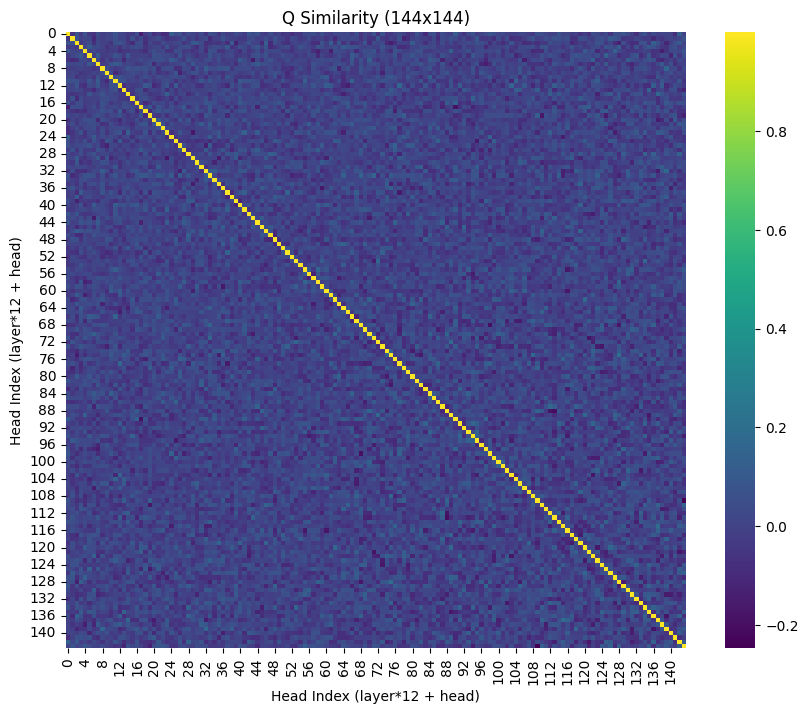

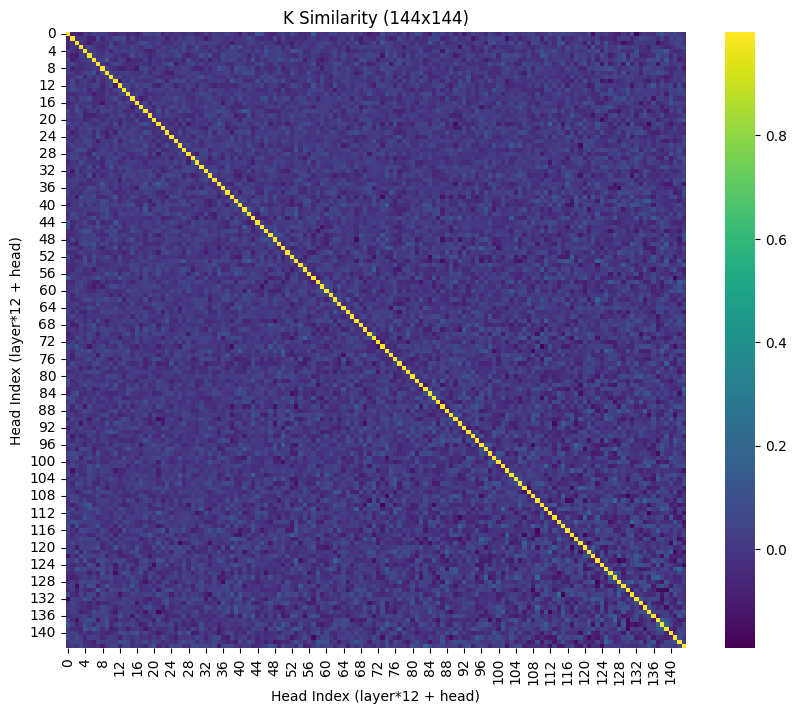

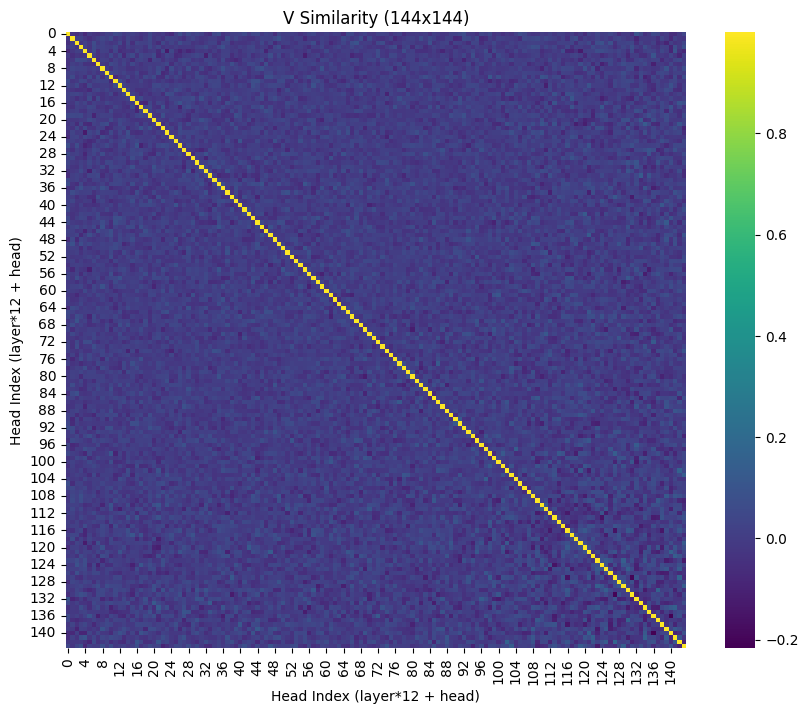

In [ ]:
import torch
import torch.nn as nn
from functools import partial
import numpy as np
import math
import librosa
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
from scipy.spatial.distance import cosine

#########################################################
# 0) 유사도 함수들
#########################################################

def cosine_similarity(u, v):
    """
    Cosine Similarity = 1 - cosine_distance
    """
    return 1.0 - cosine(u, v)

def pearson_similarity(u, v):
    """
    Pearson Correlation 계수를 유사도로 반환
    """
    corr, _ = pearsonr(u, v)
    return corr

#########################################################
# 1) 기존 QKVExtractor
#########################################################

class QKVExtractor:
    """
    Wav2Vec2Base 모델의 Wav2Vec2EncoderLayer 각 attention 모듈에 Hook을 달아,
    (batch_size, num_heads, seq_len, head_dim)의 Q/K/V 텐서를 추출.
    """
    def __init__(self, model):
        self.model = model
        
        # Hook으로 추출된 결과를 담을 dict
        self.qs = {}
        self.ks = {}
        self.vs = {}
        
        # Wav2Vec2Config 기준
        self.num_heads = model.config.num_attention_heads  # 보통 12
        self.head_dim = model.config.hidden_size // self.num_heads  # 768/12=64
        
        # model.wav2vec2.encoder.layers => 12개 레이어
        for layer_idx, layer_module in enumerate(self.model.encoder.layers):
            attn_module = layer_module.attention
            attn_module.register_forward_hook(self.make_hook(layer_idx))
            
    def make_hook(self, layer_i):
        def hook_fn(module, input, output):
            """
            module: Wav2Vec2SdpaAttention
            input:  tuple of forward inputs. 보통 (hidden_states, attention_mask, ...)
            output: tuple of forward outputs. 보통 (attn_output, attn_weights, None)
            """
            # 1) forward로 넘어온 hidden_states
            hidden_states = input[0]  # shape (batch_size, seq_len, hidden_size)
            
            # 2) Q/K/V 계산
            q = module.q_proj(hidden_states)  # (batch, seq_len, 768)
            k = module.k_proj(hidden_states)  # (batch, seq_len, 768)
            v = module.v_proj(hidden_states)  # (batch, seq_len, 768)
            
            # 3) (batch, seq_len, num_heads, head_dim) 형태로 재구성
            batch_size, seq_len, _ = q.size()
            new_shape = (batch_size, seq_len, self.num_heads, self.head_dim)
            
            q = q.view(*new_shape).permute(0, 2, 1, 3).detach().cpu()
            k = k.view(*new_shape).permute(0, 2, 1, 3).detach().cpu()
            v = v.view(*new_shape).permute(0, 2, 1, 3).detach().cpu()

            # 4) 현재 레이어의 Q/K/V를 기록
            self.qs[layer_i] = q
            self.ks[layer_i] = k
            self.vs[layer_i] = v

        return hook_fn

    def __call__(self, *args, **kwargs):
        return self.model(*args, **kwargs)

#########################################################
# 2) get_qkv_distance (유사도 버전)
#########################################################

def get_qkv_distance(qA, kA, vA, qB, kB, vB, metric="cosine"):
    """
    두 헤드의 Q/K/V (shape=(seq_len, head_dim))을 입력받아
    유사도(=similarity)를 구해 (Q_sim, K_sim, V_sim)을 리턴.
    
    metric="cosine" or "corr"
    """
    if metric == "cosine":
        dist_func = cosine_similarity
    elif metric == "corr":
        dist_func = pearson_similarity
    else:
        raise ValueError(f"Unsupported metric: {metric}")
    
    # 1) Q 유사도
    q_sim_list = []
    for i in range(qA.shape[0]):
        sim_val = dist_func(qA[i], qB[i])
        q_sim_list.append(sim_val)
    q_sim = np.mean(q_sim_list)

    # 2) K 유사도
    k_sim_list = []
    for i in range(kA.shape[0]):
        sim_val = dist_func(kA[i], kB[i])
        k_sim_list.append(sim_val)
    k_sim = np.mean(k_sim_list)

    # 3) V 유사도
    v_sim_list = []
    for i in range(vA.shape[0]):
        sim_val = dist_func(vA[i], vB[i])
        v_sim_list.append(sim_val)
    v_sim = np.mean(v_sim_list)

    return q_sim, k_sim, v_sim

#########################################################
# 3) 모든 Head(레이어+헤드) 간 Q/K/V Redundancy Matrix 계산
#########################################################

def compute_all_heads_qkv_redundancy(extractor, metric="cosine"):
    """
    12-layer x 12-head = 144개 Head 각각의 Q/K/V를 모아
    (144 x 144) 사이즈의 Q/K/V 유사도 행렬을 만든다.
    
    returns: (Q_matrix, K_matrix, V_matrix)
      각각 shape = (144, 144)
    """
    num_layers = len(extractor.qs)            # 보통 12
    num_heads_per_layer = extractor.num_heads # 보통 12
    total_heads = num_layers * num_heads_per_layer  # 144
    
    # 1) 모든 Q/K/V를 1D로 flatten (layer, head) -> index
    #    all_q[i] => i번째 (layer+head) 의 Q 텐서(shape=(seq_len, head_dim))
    all_q = []
    all_k = []
    all_v = []
    
    for layer_idx in range(num_layers):
        # shape=(batch_size=1, num_heads=12, seq_len, head_dim)
        q_layer = extractor.qs[layer_idx].squeeze(0)
        k_layer = extractor.ks[layer_idx].squeeze(0)
        v_layer = extractor.vs[layer_idx].squeeze(0)
        
        # q_layer[head_idx] => (seq_len, head_dim)
        for head_idx in range(num_heads_per_layer):
            all_q.append(q_layer[head_idx])
            all_k.append(k_layer[head_idx])
            all_v.append(v_layer[head_idx])
    
    # 2) 이제 all_q/k/v 각각 길이가 144인 리스트
    #    => (144, seq_len, head_dim)
    #    pairwise로 유사도 계산
    Q_matrix = np.zeros((total_heads, total_heads))
    K_matrix = np.zeros((total_heads, total_heads))
    V_matrix = np.zeros((total_heads, total_heads))
    
    for i in range(total_heads):
        for j in range(total_heads):
            q_sim, k_sim, v_sim = get_qkv_distance(
                all_q[i], all_k[i], all_v[i],
                all_q[j], all_k[j], all_v[j],
                metric=metric
            )
            Q_matrix[i, j] = q_sim
            K_matrix[i, j] = k_sim
            V_matrix[i, j] = v_sim
    
    return Q_matrix, K_matrix, V_matrix


#########################################################
# 4) 예시 사용
#########################################################
from transformers import Wav2Vec2Model, Wav2Vec2Processor

# 모델 로드
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-100h")
model = Wav2Vec2Model.from_pretrained("facebook/wav2vec2-base-100h")

# Hook 등록
extractor = QKVExtractor(model)

# 입력 오디오 준비
audio_filepath = "/home/kobie/workspace/data/LibriSpeech/dev-clean/84/121123/84-121123-0000.flac"
waveform, sr = librosa.load(audio_filepath, sr=16000, mono=True)
input_values = processor(waveform, sampling_rate=16000, return_tensors="pt").input_values

# Forward (hook 내부에서 Q/K/V 저장됨)
with torch.no_grad():
    _ = extractor(input_values)  # output_attentions=True 설정 상관없이 Q/K/V는 hook에서 뽑힙니다.

# 144x144 Redundancy Matrix 생성
Q_mat, K_mat, V_mat = compute_all_heads_qkv_redundancy(extractor, metric="cosine")

print("Q_mat shape:", Q_mat.shape)  # (144, 144)
print("K_mat shape:", K_mat.shape)  # (144, 144)
print("V_mat shape:", V_mat.shape)  # (144, 144)

# 히트맵 시각화 예시
plt.figure(figsize=(10, 8))
sns.heatmap(Q_mat, cmap='viridis')
plt.title("Q Similarity (144x144)")
plt.xlabel("Head Index")
plt.ylabel("Head Index")
plt.show()

# 필요 시 K, V도 같은 식으로 heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(K_mat, cmap='viridis')
plt.title("K Similarity (144x144)")
plt.xlabel("Head Index")
plt.ylabel("Head Index")
plt.show()

plt.figure(figsize=(10, 8))
sns.heatmap(V_mat, cmap='viridis')
plt.title("V Similarity (144x144)")
plt.xlabel("Head Index")
plt.ylabel("Head Index")
plt.show()


# QK Attention map 확인

In [ ]:
####################
# (예시) 모델 로드
####################
from transformers import Wav2Vec2Model, Wav2Vec2Processor
import librosa

processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-100h")
model = Wav2Vec2Model.from_pretrained("facebook/wav2vec2-base-100h")


# Hook 세팅을 위해 래퍼 생성
extractor = QKVExtractor(model)

# Forward
audio_file = "/home/kobie/workspace/data/LibriSpeech/dev-clean/84/121123/84-121123-0000.flac"

waveform, sr = librosa.load(audio_file, sr=16000, mono=True)

# 입력 전처리
input_values = processor(waveform, sampling_rate=16000, return_tensors="pt").input_values

# Attention 출력을 받기 위해 forward 시 output_attentions=True 설정
with torch.no_grad():
    outputs = model(
        input_values, 
        output_attentions=True  # <-- Multi-Head Attention 가중치를 반환
    )


# 이제 extractor.qs, extractor.ks, extractor.vs에
# layer별로 Q/K/V가 저장됨.

####################
# Q/K/V Distance 계산
####################
layer_idx = 8  # 0번 레이어에서 Head 간 Q/K/V 유사도 비교
dist_matrix = compute_qkv_distances_for_layer(extractor, layer_idx, metric="cosine")

print(dist_matrix.shape)  # (num_heads, num_heads, 3)
print("Head0 vs Head1의 Q/K/V distance:", dist_matrix[8, 10])  # [q_dist, k_dist, v_dist] 
